In [1]:
import numpy as np
import matplotlib.pyplot as plt

You draw 7 cards from a suit of cards, without replacement. What is the probability that all 4 suits are in the deck of cards?

Before going through the process of solving this question and generalizing it to any number of cards and so on, let's simulate the process of selecting 7 cards from a deck without replacement. This will also give a decent enough 'sanity check' to compare the answer to. So pick a random seed, and get started:

In [2]:
decksize = 52
suits = 4
cardspersuit = 13
deck = np.tile(np.arange(suits,dtype=int),cardspersuit)
deck

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3])

It isn't necessary to specify the card number, as we only really care about cards being unique so that they can be selected without replacement, and then each number here can code for a suit. So how do we go about selecting 7 items from this array without replacement?

In [3]:
k = 7
np.random.seed(4321)
cardset = np.random.choice(deck,size=k,replace=False)
cardset

array([0, 1, 3, 1, 2, 1, 0])

In this case, there are four suits in our set of 7 cards, so this would get a pass. An easy way to check for this would be to compute the length of the number of unique values, and then compare it to 4: 

In [4]:
len(np.unique(cardset)) == suits

True

So it should be relatively easy to give this 10,000 runs in a simulation and count the number of unique suits represented in each cardset:

In [5]:
n = 10000
uniquecards = np.zeros(n,dtype=int)
fullrep = np.zeros(n,dtype=int)
for i in range(n):
    cardset = np.random.choice(deck,size=k,replace=False)
    uniquecards[i] = len(np.unique(cardset))
    fullrep[i] = (uniquecards[i] == suits)
np.mean(fullrep)

0.5692

So out of 10,000 simulations, about 57% had a set of 7 cards with at least one card from each suit. We can graph the number of unique suits in the set:

In [6]:
uniques = np.bincount(uniquecards)[1:]
uniques

array([   1,  331, 3976, 5692], dtype=int64)

<BarContainer object of 4 artists>

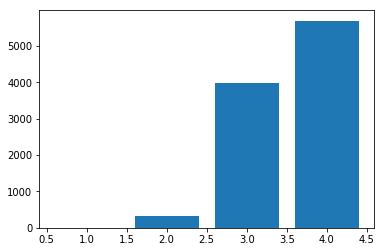

In [7]:
plt.bar(1+np.arange(suits,dtype=int),uniques)

Since each run of the simulation is independent, then we can figure out a 99% confidence interval for our probability:

In [8]:
alpha = .01
p_hat = uniques[-1]/n
sem = np.sqrt(p_hat*(1-p_hat)/n)
from scipy import stats
z = stats.norm.ppf(1-alpha/2)
ci99p = p_hat + np.array([-1,1])*z*sem
print(ci99p)

[0.5564448 0.5819552]


This is a 99% Wald Confidence Interval for the true probability. Let's see how this compares to the actual answer. There are a couple of different methods to figure out the answer here. The first method isn't the one that I initially got the answer with, but someone online suggested it, and I personally thought that it made more sense and was easier to explain and harder to mess up on the counting of combinations.

So of the $\binom{52}{7}$ ways there are to select 7 cards without replacement from the deck, you can exclude the sets of 7 cards that don't include one suit, but then this undercounts those that are missing two suits, so you can count those, and then eventually, this reduces using the Principle of Inclusion Exclusion to counting the following set:

$\Sigma_{i=0}^{4}$ $(-1)^i$ $\binom{4}{i}$ $\binom{52-13i}{7}$ / $\binom{52}{7}$

Which can be coded as:

In [9]:
from scipy import special
i = np.arange(suits+1,dtype=int)
p1 = sum(((-1)**i) * special.binom(suits,i) * special.binom(decksize - cardspersuit*i,k))/special.binom(decksize,k)
print(p1)

0.5695780439835508


This is relatively close to the answer, and it was relatively easy to derive this using the principle of inclusion / exclusion. Another method that involves more calculations and hence potentially more error is to figure it out using the number of permutations for each set of 7 cards.

In the case that we are drawing 7 cards without replacement, there will be three cases that we might consider:

1. One suits has 4 cards present, and the other 3 suits have 1 card present AKA (4,1,1,1)
2. One suit has 3 cards, another has 2, and two suits have 1 card, AKA (3,2,1,1)
3. Three suits have 2 cards, one has 1, AKA (2,2,2,1)

The number of possible sequences for k cards drawn without replacement here, up to 13, is given by the $(k-4)^{th}$ term of OEIS sequence number A001400. Then, for each of these subcases, which are exhaustive for sets of 7 cards selected without replacement and the number of cards in each suit, we can find the number of ways to get this from the total number, which is (52P7) = 52*51*...*(52-7+1) = 52*51*...*46 = 674,274,182,400 ways. This will be our denominator rather than $\binom{52}{7}$, which is much smaller (by a factor of 7! = 5040), because we are counting the number of permutations here for each group.

So for the first case, (4,1,1,1), there are 4P1 ways to arrange the suits in this manner, then each has $\binom{7}{4,1,1,1}$ ways of being selected in order, and then for specific cards, there are 13P4*$(13P1)^3$ ways, or a total of:

In [10]:
#function for permutations
def perm(n,k):
    return int(special.factorial(n) / special.factorial(n-k))

#function for multinomial coefficients
def multnom(n,k):
    m = len(k)
    u = 1
    for i in range(m):
        u *= special.factorial(k[i])
    return int(special.factorial(n) / u)

#test
print(perm(52,4),multnom(7,[4,1,1,1]))

6497400 210


In [11]:
part1 = perm(4,1)*multnom(7,[4,1,1,1])*perm(13,4)*(perm(13,1)**3)
part1

31668436800

So the probability of encountering this subcase, AKA The probability that we choose 7 cards from a deck without replacement and we encounter all the suits AND one suit has 4 cards would be:

In [12]:
part1 / perm(52,7)

0.046966705276004946

For the second one, we would need 4P2 = 12 for (3,2,1,1), since there are 12 ways to have the group with 3 cards and the suit with 2 cards in 4 slots. Then there are $\binom{7}{3,2,1,1}$ ways for the ordering, and then for specific cards, you have (13P3)*(13P2)*$(13P1)^2$ or:

In [13]:
part2 = perm(4,2)*multnom(7,[3,2,1,1])*perm(13,3)*perm(13,2)*(perm(13,1)**2)
part2

228012744960

With probability:

In [14]:
part2 / perm(52,7)

0.3381602779872356

Lastly, we consider three suits having 2 cards each and 1 suit with only one card. There, we would have the total number of ways to get there as:

In [15]:
part3 = perm(4,1)*multnom(7,[2,2,2,1])*perm(13,1)*(perm(13,2)**3)
part3

124370588160

...with a probability of:

In [16]:
part3 / perm(52,7)

0.18445106072031034

Adding these up, we obtain:

In [17]:
p2 = (part1 + part2 + part3)/perm(52,7)
print(p1,p2)

0.5695780439835508 0.5695780439835508


We get the same number. Apart from figuring out the actual probability, one could ask how the probability of all the suits in a set of 7 without replacement will compare to the case where we do have replacement. Since replacing each draw reduces the chance that a new suit is selected, since the same card from a suit that has already appeared is placed back, then it is fairly easy to deduce that the probability with replacement will be less than the probability without replacement. For example, if we were to consider the case where we draw only 4 cards, and try to find the probability that all 4 suits are in the set, with and without replacement, then:

For the case without replacement, there's only one way for all four suits to be present- one card for each set. So we would have 4! * $(13P1)^4$ / 52P4 or:

In [18]:
special.factorial(4)*(perm(13,1)**4)/perm(52,4)

0.10549819927971188

For the case where we do have replacement, we are instead going to get 4! / $4^4$ = 3/32, or roughly:

In [19]:
special.factorial(4)/(4**4)

0.09375

So this probability is indeed higher. What about the probability for the case WITH replacement for 7 cards drawn? In this case, we'd again expect this probability to be strictly less than the probability for the case without replacement. The way that one can reason this out is that every card that gets selected has their suit recorded, and then goes back, which means that the card and hence a suit that has already appeared has a likelihood of appearing again, which doesn't happen if we do not have replacement.

Again, we can simulate this out, and find a confidence interval:

In [20]:
n = 10000
uniquecards = np.zeros(n,dtype=int)
fullrep = np.zeros(n,dtype=int)
for i in range(n):
    cardset = np.random.choice(deck,size=k) #note that default for replace in np.random.choice is True
    uniquecards[i] = len(np.unique(cardset))
    fullrep[i] = (uniquecards[i] == suits)
np.mean(fullrep)

0.5143

In [21]:
uniques = np.bincount(uniquecards)[1:]
p_hat = uniques[-1]/n
sem = np.sqrt(p_hat*(1-p_hat)/n)
from scipy import stats
z = stats.norm.ppf(1-alpha/2)
ci99p = p_hat + np.array([-1,1])*z*sem
print(ci99p)

[0.50142612 0.52717388]


The exact value can be deduced as follows:

1. For (4,1,1,1), you need $\binom{4}{1}$ by the Multinomial(7,$p_i$=$\frac{1}{4}$) = $\binom{7}{4,1,1,1}$$\frac{1}{4^7}$
2. For (3,2,1,1), you need $\binom{4}{2}$ by the Multinomial(7,$p_i$=$\frac{1}{4}$) = $\binom{7}{3,2,1,1}$$\frac{1}{4^7}$
1. For (2,2,2,1), you need $\binom{4}{1}$ by the Multinomial(7,$p_i$=$\frac{1}{4}$) = $\binom{7}{2,2,2,1}$$\frac{1}{4^7}$

This is similar to the case without replacement, but it will be, by necessity, less than the value without replacement:

In [22]:
combos = (perm(4,1)*multnom(7,[4,1,1,1]) + perm(4,2)*multnom(7,[3,2,1,1]) + perm(4,1)*multnom(7,[2,2,2,1]))
combos

8400

In [23]:
p = combos/(4**7)
print(p)

0.5126953125


This is within the confidence interval. The main thing that would conceivably make the case where we do have replacement more analytically tractable is that since the bin counts for each suit upon each simulation of 7 cards, without replacement, then the probability for each suit is the same for each draw, at $\frac{1}{4}$. However, one still needs to figure out the number of Permutations for each possible arangement in the bincounts for each suit. For example, for (4,1,1,1), this defines all sets of 7 cards drawn from the deck, and in both the case where there is replacement and where there isn't. you have this being one out of three possible bincounts that are in descending order. For example, 4 cards from Hearts, and 1 card each from Spades, Clubs and Diamonds, and then the case where 4 cards are Diamonds and each of the other suits has 1 card each, both are classified as (4,1,1,1). So then for the number of such 4-tuples given 7 cards drawn, you would have to figure out both the number of and the 4-tuple combinations themselves that satisfy this criteria (for 7 cards, it would be 3, as previously discussed) and for each of these 4-tuples, one would also need the number of ways that four distinct suits would be arrangeable into this particular 4-tuple.

So, when 7 cards are drawn from a deck of 52 cards, 13 in each suit, Diamonds (D), Clubs (C), Hearts (H), and Spades (S), if you have to find the number of possible ways to get (4,1,1,1), you could list out all of the possible 4-tuples for (C,D,H,S):

1. (4 C,1 D,1 H,1 S)
2. (1 C,4 D,1 H,1 S)
3. (1 C,1 D,4 H,1 S)
4. (1 C,1 D,1 H,4 S)

So there are a total of four different ways here. In general, depending on the bin count of the 4-tuple itself, we can figure out this combination for each thing. So for example:

1. (4,1,1,1) has 1 4 and 3 1s, so there are $\frac{4!}{(4-1)!}$ = $4$ ways to get this, which is a permutation
2. (3,2,1,1) has 1 3, 1 2 and 2 1s, so there are $\frac{4!}{(4-2)!}$ = $12$ ways
3. (2,2,2,1) has 3 2s and 1 1, so there are $\frac{4!}{(4-1)!}$ = 4 ways...

So this number is the permutation, which will differ from that used in the case with replacement, which uses binomial coefficients. 

The one thing that doesn't vary whether there is replacement or not is both the 4-tuples that add up to 7 or whatever number k $\geq$ 4, or the number of such 4-tuples for a particular k. Fortunately, there is a recursive way to figure this out, but first, it typically helps to define what we mean here:

For the case where we draw four cards, the only kind that we can really have where we have all four suits in the set is 1 card for each suit, AKA (1,1,1,1). If we draw four cards, we can also have cases where we have:

1. 1 suit in the set, for example, four 'Diamonds', as (4,0,0,0)
2. 2 suits in the set, for example (3,1,0,0) or (2,2,0,0)
3. 3 suits in the set, for example (2,1,1,0)

This defines the total number of ways that we can bin a set of four distinct objects into four distinct bins. There are therefore 1+2+1+1=5=$B_4$ ways to partition a set of four distinct objects, which is know as the Bell Number, and related to the Stirling Numbers of the Second Kind. If we want to obtain the 4-tuples that have all suits in a set of 5 cards, we can continue by taking the case for k=4 and adding in a basic solution, $e_1$ = (1,0,0,0). There are four basic solutions. Of course, we re-arrange into descending order after adding this and compare with the current solution set. This can easily be programmed:

(1,1,1,1) + (1,0,0,0) = (2,1,1,1)

Notice that adding in other basic solutions of rank one, like (0,1,0,0), will produce the same result after we order the 4-tuple by descending order. So this means that the only way to have all 4 suits in a deck of 5 cards, selected with or without replacement, is (2,1,1,1).